In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

cudnn.benchmark = True
plt.ion()  

In [2]:
#print(torch.cuda.is_available())
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/user/Desktop/fer2013_master/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

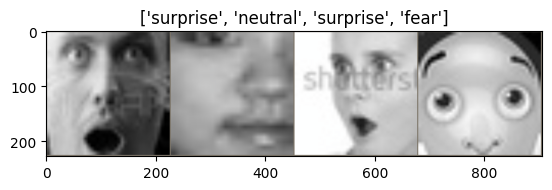

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [3]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features

model_ft.classifier = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


In [4]:
torch.save(model_ft.state_dict(), "C:/Users/user/Desktop/fer2013_master/model/effifer2023.pt")

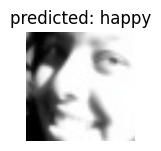

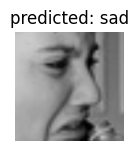

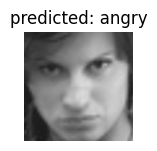

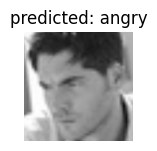

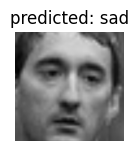

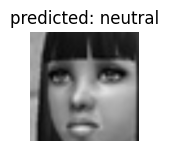

In [12]:
visualize_model(model_ft)

In [4]:
#FEPlus test-transform
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = datasets.ImageFolder("C:/Users/user/Desktop/fer2013_master/test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)

In [5]:
test_raf_data = datasets.ImageFolder("C:/Users/user/Desktop/fer2013_master/validation", transform=test_transform)
raf_loader = torch.utils.data.DataLoader(test_raf_data, batch_size = 16, num_workers = 0)

In [7]:
def test(model, criterion, test_loader):
# monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.


    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1))*(loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [6]:
#model = torch.load("C:/Users/user/Desktop/fer2013_master/model/effifer2023.pt")
model_ft.load_state_dict(torch.load("C:/Users/user/Desktop/fer2013_master/model/effifer2023.pt"))

<All keys matched successfully>

In [8]:
test(model_ft, criterion, test_loader) #for FERPlus FERPlus için

Test Loss: 1.956547


Test Accuracy: 15% (1081/7048)


Text(92.25, 0.5, 'True labels')

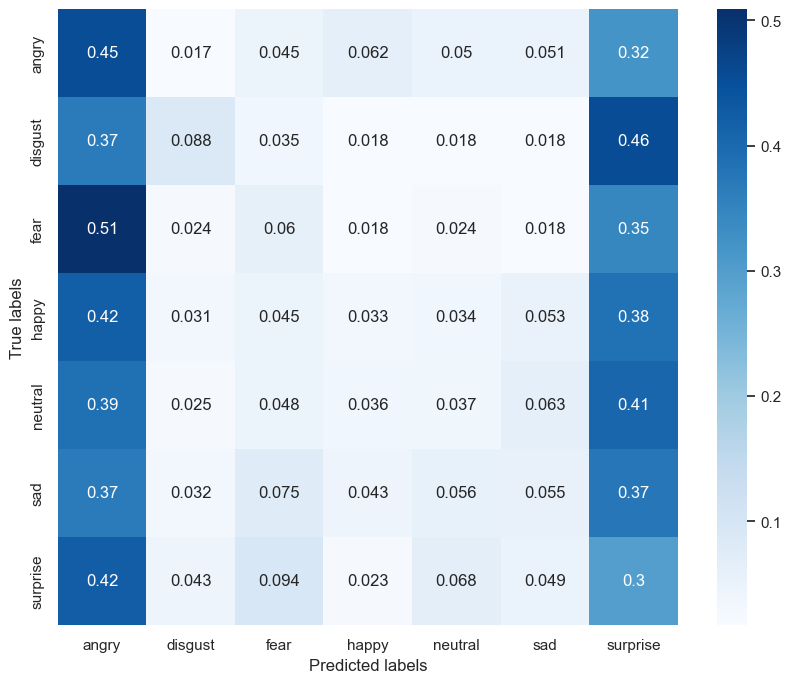

In [5]:
#FERPlus confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
model_ft.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")


In [10]:
test(model_ft, criterion, raf_loader) #for facial expression recognition için

Test Loss: 1.947245


Test Accuracy: 16% (1178/7066)


In [6]:
#Facial expression confusion matrix
# FERPlus confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']
model_ft.eval()
with torch.no_grad():
    for images, labels in raf_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype(
    'float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

In [6]:
def load_input_image(img_path):
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 244)),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = prediction_transform(image)[:3, :, :].unsqueeze(0)
    return image

In [7]:
def predict_emotion(model, class_names, img_path):
    img = load_input_image(img_path)
    model = model.cpu()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [8]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
img_path = "C:/Users/user/Pictures/Camera Roll/image.jpg"
print(predict_emotion(model_ft, class_names, img_path))

happy


In [13]:
img_path_2 = "C:/Users/user/Pictures/2016-03/graduation_two.jpg"
print(predict_emotion(model_ft, class_names, img_path_2))

fear
